In [1]:
# variational bayesian principal component analysis 
# based on Ilin & Raiko 2010 and associated code
# for dxn data matrix assume Y assume that row j:
# y_j = W*x_j + m + e_j, with
# p(x_j) = N(x_j; 0, I)
# p(e_j) = N(e_j; 0, v_yI)
# p(m) = N(m; 0, v_mI)
# p(W) = N(w_:k; 0, v_wkI)

# if data is missing instead consider 
# y_ij = w_i^Tx_j + m_i + e_ij for all i,j in O
# see paper for details on update rules 

# packages used
import numpy as np
import pandas as pd
from numpy.random import randn
from scipy.linalg import orth, subspace_angles
from numpy.linalg import inv, eig, det, norm
from numpy.random import seed
import matplotlib.pyplot as plt

# read in the data
df = pd.read_csv(r'PulotuCleaned.csv')
dfAll = pd.read_csv(r'PulotuCurrent.csv')
del dfAll['Culture ']
del dfAll['Island_type']
del dfAll['Pre-Austronesian_population']
del dfAll['Distance_to_closest_landmass_inhabited_by_a_different_culture_(km)']
del dfAll['Latitude']
del dfAll['Longitude']
del dfAll['Island_Size_(km²)']
del dfAll['Distance_to_African_or_Asian_mainland_(km)_']
del df['Number_of_islands_inhabited_by_culture']
del df['Maximum_elevation_(meters)']

names1 = np.array(dfAll.columns)
names2 = np.array(df.columns)

for j in range(0,len(names2)):
    for k in range(0,len(names1)):
        if names1[k] == names2[j]:
            dfAll[names1[k]] = df[names2[j]]
            break
dfAll.values

array([[nan,  3.,  1., ...,  2.,  2.,  2.],
       [ 3., nan,  1., ..., nan,  1.,  3.],
       [ 2.,  4.,  3., ..., nan,  3.,  1.],
       ...,
       [ 2.,  4.,  3., ...,  2., nan,  2.],
       [ 2.,  3.,  4., ...,  2.,  1.,  3.],
       [ 3.,  3.,  1., ...,  2.,  2.,  2.]])

In [2]:
def SubtractMu(Mu, _X_, M): # something wrong here
    data_ = _X_.copy()
    n2 = data_.shape[1]
    data_ = data_ - np.multiply(np.tile(Mu,(n2,1)).T,M)
    return data_

In [3]:
def InitParams(n1, n2, ncomp, nobscomb):
    seed(0)
    A = orth(randn(n1,ncomp))
    Av = []
    for i in range(0,n1):
        Av.append(np.eye(ncomp))
    Muv = np.ones([n1,1])
    V = 1
    S = randn(ncomp,n2)
    Sv = []
    for j in range(0,nobscomb):
        Sv.append(np.eye(ncomp))
    return A, S, V, Av, Sv, Muv
    

In [4]:
def compute_rms(XX, AA, SS, MM, ndata):
    errMx = np.multiply((XX - np.matmul(AA,SS)),MM)
    rms = np.divide(np.sum(np.sum(np.square(errMx),axis=0)), ndata)
    return rms, errMx
    

In [5]:
def RotateToPCA(A, Av, S, Sv):
    A_ = A.copy()
    Av_ = Av.copy()
    S_ = S.copy()
    Sv_ = Sv.copy()
    n1 = A_.shape[0]
    n2 = S_.shape[1]
    mS = np.mean(S_, axis=1)
    dMu_ = np.matmul(A_,mS)
    S_ = S_ - np.tile(mS,(n2,1)).T
    covS = np.matmul(S_,S_.T)
    for j in range(0,n2):
        covS = covS + Sv_[j]
    covS = np.divide(covS,n2)
    D, VS = eig(covS)
    idxS = D.argsort()[::1]   
    D = D[idxS]
    VS = VS[:,idxS]
    D = np.diag(D)
    RA = np.matmul(VS,np.sqrt(D))
    A_ = np.matmul(A_,RA)
    covA = np.matmul(A_.T,A_)
    for i in range(0,n1):
        Av_[i] = np.matmul(np.matmul(RA.T,Av_[i]),RA)
        covA = covA + Av_[i]
    covA = np.divide(covA,n1)
    DA, VA = eig(covA)
    idxA = DA.argsort()[::-1]   
    DA = DA[idxA]
    VA = VA[:,idxA]
    A_ = np.matmul(A_,VA)
    for i in range(0,n1):
        Av_[i] = np.matmul(np.matmul(VA.T,Av_[i]),VA)
    R = np.matmul(np.matmul(VA.T,np.diag(1/np.sqrt(np.diag(D)))),VS.T)
    S_ = np.matmul(R,S_)
    for j in range(0,len(Sv_)):
        Sv_[j] = np.matmul(np.matmul(R,Sv_[j]),R.T)
    return dMu_, A_, Av_, S_, Sv_
    
    


 

In [6]:
def CF_FULL(X, A, S, Mu, M):
    n2 = X.shape[1]
    return norm(np.multiply(X-np.matmul(A,S)-np.tile(Mu,(n2,1)).T,M),'fro')**2

In [7]:
def Accuracy(XXX, A, S, Mu, M, ndata):
    ret = np.multiply((np.round(XXX) - np.round(np.matmul(A,S)+np.tile(Mu,(XXX.shape[1],1)).T)),M)
    ret = ret.flatten()
    idxAcc = np.where(ret > 0)
    idxAcc = idxAcc[0]
    wrong = len(idxAcc)/ndata
    return 1-wrong

In [8]:
def pca_full(X, ncomp, maxiters):
    data = X.copy()
    data = data.T
    n1, n2 = data.shape
    # create missing values matrix 
    ind = np.isnan(data)
    M = np.zeros(ind.shape)
    for i in range(0, ind.shape[0]):
        for j in range(0, ind.shape[1]):
            if ind[i,j] == False:
                M[i,j] = 1
    eps = np.finfo(float).eps
    data[data==0] = eps
    data[np.isnan(data) == True] = 0
    Nobs_i = np.sum(M,axis=1)
    ndata = int(np.sum(Nobs_i))
    IX, JX = np.nonzero(data) 
    nobscomb = n2;
    # initialize model 
    A, S, V, Av, Sv, Muv = InitParams(n1, n2, ncomp, nobscomb)
    Va = 1000*np.ones([1,ncomp])
    Vmu = 1000
    Mu = np.divide(np.sum(data,axis=1),Nobs_i)
    data = SubtractMu(Mu, data, M)
    rms, errMx = compute_rms(data, A, S, M, ndata)
    print('rms: %f' % rms)
    Aold = A
    
    # parameters of prior for variance params 
    hpVa = 0.001
    hpVb = 0.001
    hpV = 0.001
    
    for its in range(0,maxiters):
        # burn in, prior is not updated at the beginning of learning to avoid killing sources
        if its >= 0:
            # update Va, Vmu
            Vmu = np.sum(np.square(Mu))
            Vmu = Vmu+np.sum(Muv)
            Vmu = np.divide((Vmu + 2*hpVa),(n1+2*hpVb))
            Va = np.sum(np.square(A),axis=0)
            for i in range(0,n1):
                Va = Va+np.diag(Av[i]).T
            Va = np.divide((Va+2*hpVa),(n1+2*hpVb))
        
        # update Mu
        dMu = np.divide(np.sum(errMx,axis=1),Nobs_i) 
        Muv = np.divide(V, (Nobs_i + np.divide(V,Vmu)))
        th = 1+np.divide(np.divide(V,Nobs_i),Vmu)
        th = np.divide(1,th)
        Mu_old = Mu
        Mu = np.multiply(th,Mu+dMu)
        dMu = Mu - Mu_old
        data = SubtractMu(dMu, data, M)
        
        # update S
        for j in range(0,n2):
            A_j = np.multiply(np.tile(M[:,j],(ncomp,1)).T,A)
            Psi = np.matmul(A_j.T,A_j) + V*np.eye(ncomp)
            idx = np.where(M[:,j] > 0) 
            idx = idx[0]
            for i in range(0,len(idx)):
                Psi = Psi + Av[idx[i]]
            invPsi = inv(Psi)
            S[:,j] = np.matmul(np.matmul(invPsi,A_j.T), data[:,j])
            Sv[j] = V*invPsi
        # rotate to PCA
        dMu, A, Av, S, Sv = RotateToPCA(A, Av, S, Sv) # <- something is wrong here?
        data = SubtractMu(dMu, data, M)
        Mu = Mu + dMu
        # update A
        for i in range(0,n1):
            S_i = np.multiply(np.tile(M[i,:],(ncomp,1)),S)
            Phi = np.matmul(S_i,S_i.T) + np.diag(V/Va)
            idx = np.where(M[i,:] > 0)
            idx = idx[0]
            for j in range(0,len(idx)):
                Phi = Phi + Sv[j]
            invPhi = inv(Phi)
            A[i,:] = np.matmul(np.matmul(data[i,:],S_i.T),invPhi)
            Av[i] = V*invPhi
        rmsOld = rms
        rms, errMx = compute_rms(data, A, S, M, ndata)
        
        
        # update V
        sXv = 0
        for r in range(0, ndata):
            sXv = sXv + np.matmul(np.matmul(A[IX[r],:],Sv[JX[r]]),A[IX[r],:].T)
            sXv = sXv + np.matmul(np.matmul(S[:,JX[r]].T,Av[IX[r]]),S[:,JX[r]]) + np.sum(np.sum(np.multiply(Sv[JX[r]],Av[IX[r]]),axis=0))
        sXv = sXv + np.sum(Muv[IX])
        sXv = sXv + (rms**2)*ndata
        V = (sXv + 2*hpV)/(ndata+2*hpV)
        
        if its > 0:
            angleAold = angleA
        angleA = subspace_angles(A, Aold)
        angleA = angleA[0]
        Aold = A
        cost = CF_FULL(data, A, S, Mu, M)
        acc = Accuracy(data, A, S, Mu, M, ndata)
        print("iteration: %i, cost: %f, rms : %f, angle : %f, accuracy: %f" % (its+1,cost,rms,angleA,acc))
        if its > 0:
            if np.abs(rms-rmsOld) < 1e-7:
                print('terminated early due to lack of change in rms')
                break
    dMu, A, Av, S, Sv = RotateToPCA(A, Av, S, Sv)
    Mu = Mu+dMu
    cv = {
        "A": Av,
        "S": Sv,
        "Mu": Muv
            }
    metrics = {
        "cost": cost,
        "rms": rms,
        "angle": angleA,
        "accu": acc
            }
        
    Xrec = np.matmul(A,S)+np.tile(Mu,(data.shape[1],1)).T
    Vr = np.zeros(data.shape)
    for i in range(0,data.shape[0]):
        for j in range(0,data.shape[1]):
            Vr[i,j] = np.matmul(np.matmul(A[i,:],Sv[i]), A[i,:].T) + np.matmul(np.matmul(S[:,j].T,Av[i]),S[:,j]) + np.sum(np.sum(np.multiply(Sv[j], Av[i]),axis=0)) + Muv[i]
    hp = {
        "Va": Va,
        "Vmu": Vmu,
        "Vr": Vr
            }

    return A, S, Mu, V, Xrec, cv, hp, metrics

    
      
    





In [9]:
costs = np.zeros([45, 1])
rmss = np.zeros([45, 1])
angles = np.zeros([45, 1])
accs = np.zeros([45, 1])
for j in range(2,47):
    A, S, Mu, V, Xrec, cv, hp, metrics = pca_full(dfAll.values,j,50)
    costs[j-2] = metrics['cost']
    rmss[j-2] = metrics['rms']
    angles[j-2] = metrics['angle']
    accs[j-2] = metrics['accu']
#print(np.matmul(A,S).shape)
#Xrec = np.tile(Mu,(1,dfAll.values.T.shape[1]))+np.matmul(A,S)



rms: 0.596759
iteration: 1, cost: 15153.939673, rms : 0.557714, angle : 0.929386, accuracy: 0.946070
iteration: 2, cost: 15226.639057, rms : 0.550273, angle : 0.491810, accuracy: 0.946070
iteration: 3, cost: 15027.877990, rms : 0.507465, angle : 0.263948, accuracy: 0.949415
iteration: 4, cost: 14815.207379, rms : 0.460622, angle : 0.159890, accuracy: 0.958403
iteration: 5, cost: 14748.277647, rms : 0.445287, angle : 0.111503, accuracy: 0.963211
iteration: 6, cost: 14733.618118, rms : 0.442544, angle : 0.079568, accuracy: 0.965092
iteration: 7, cost: 14726.883215, rms : 0.441787, angle : 0.059295, accuracy: 0.965928
iteration: 8, cost: 14722.899931, rms : 0.441450, angle : 0.045781, accuracy: 0.966555
iteration: 9, cost: 14720.442938, rms : 0.441263, angle : 0.036095, accuracy: 0.966555
iteration: 10, cost: 14718.852502, rms : 0.441149, angle : 0.028819, accuracy: 0.966973
iteration: 11, cost: 14717.781497, rms : 0.441078, angle : 0.023186, accuracy: 0.966973
iteration: 12, cost: 14717.

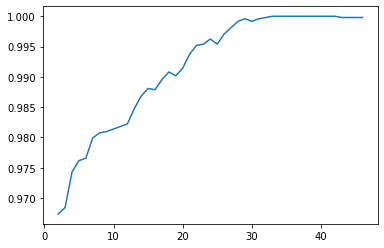

In [10]:
plt.plot(np.linspace(2,46,45), accs)

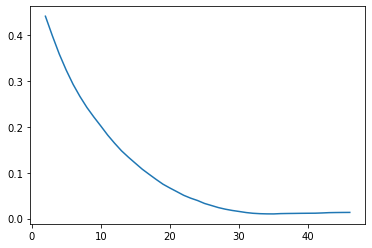

In [11]:
plt.plot(np.linspace(2,46,45), rmss)

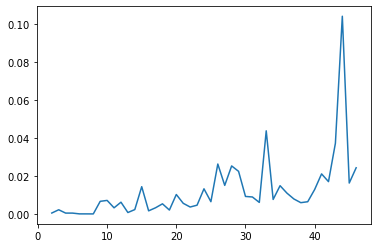

In [12]:
plt.plot(np.linspace(2,46,45), angles)


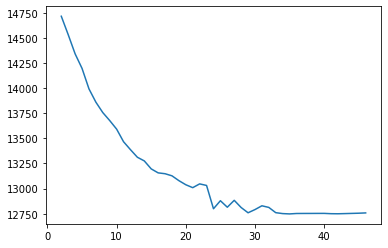

In [13]:
plt.plot(np.linspace(2,46,45), costs)

In [14]:
 A, S, Mu, V, Xrec, cv, hp, metrics = pca_full(dfAll.values,30,120)

rms: 1.210099
iteration: 1, cost: 15270.838430, rms : 0.541531, angle : 1.141256, accuracy: 0.951296
iteration: 2, cost: 14942.950267, rms : 0.499872, angle : 0.686367, accuracy: 0.952759
iteration: 3, cost: 14595.054450, rms : 0.419107, angle : 0.425732, accuracy: 0.961120
iteration: 4, cost: 14243.048492, rms : 0.341580, angle : 0.250775, accuracy: 0.972199
iteration: 5, cost: 13978.165792, rms : 0.282943, angle : 0.168844, accuracy: 0.977007
iteration: 6, cost: 13747.169165, rms : 0.235216, angle : 0.152272, accuracy: 0.978679
iteration: 7, cost: 13534.715126, rms : 0.194186, angle : 0.142092, accuracy: 0.980351
iteration: 8, cost: 13387.952810, rms : 0.163184, angle : 0.142063, accuracy: 0.982441
iteration: 9, cost: 13282.113192, rms : 0.139740, angle : 0.135171, accuracy: 0.986204
iteration: 10, cost: 13181.727981, rms : 0.117641, angle : 0.125073, accuracy: 0.987249
iteration: 11, cost: 13108.573188, rms : 0.101219, angle : 0.122846, accuracy: 0.989758
iteration: 12, cost: 13055.

In [15]:
np.round(Xrec.T[:,1])

array([ 3.,  3.,  4.,  3.,  4.,  4.,  3.,  3.,  4.,  2.,  2.,  4.,  3.,
        0.,  4.,  4.,  3.,  4.,  2.,  3.,  1.,  4.,  3.,  4.,  4., -0.,
        2.,  3.,  3.,  7.,  4.,  3.,  4.,  3.,  3.,  3.,  4.,  3.,  2.,
        4.,  4.,  4.,  3.,  3.,  1.,  3.,  3.,  2.,  3.,  4.,  4.,  4.,
        1.,  4.,  2.,  3.,  0.,  1.,  3.,  3.,  3.,  5.,  2.,  2.,  3.,
        3.,  3.,  3.,  3.,  2.,  3.,  3.,  1.,  5.,  3.,  2.,  6.,  1.,
        5.,  2.,  4.,  1.,  4.,  3.,  1.,  3.,  4.,  3.,  3.,  2.,  4.,
        4.,  3.,  3.,  4.,  3.,  4.,  4.,  3.,  3.,  3.,  4.,  3.,  4.,
        4.,  3.,  4.,  3.,  4.,  4.,  4.,  4.,  1.,  4.,  3.,  3.])

In [16]:
dfAll.values[:,1]

array([ 3., nan,  4.,  3.,  4.,  4.,  3., nan,  4.,  2.,  2.,  4.,  3.,
       nan,  4.,  4.,  3.,  4., nan,  3.,  1.,  4.,  3.,  4.,  4., nan,
        2.,  3.,  3., nan,  4.,  3.,  4.,  3.,  3.,  4.,  4.,  3.,  2.,
        4.,  4.,  4.,  3., nan,  1.,  3.,  3.,  2.,  3., nan,  4.,  4.,
        1.,  4.,  2.,  3., nan, nan,  3.,  3.,  3., nan,  2.,  2.,  3.,
        3.,  3.,  3.,  3., nan,  3., nan,  1., nan,  3.,  2., nan,  1.,
       nan,  2.,  4., nan,  4.,  3.,  1.,  3., nan,  3.,  3.,  2.,  4.,
        4., nan,  3.,  4.,  3.,  4.,  4.,  3.,  3.,  3.,  3.,  3.,  4.,
        4.,  3.,  4.,  3.,  4.,  4.,  4.,  4.,  1.,  4.,  3.,  3.])

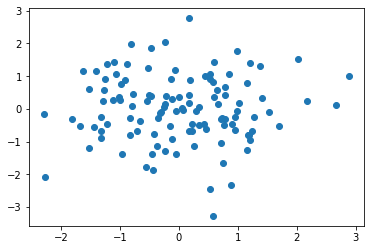

In [17]:
plt.scatter(S[0,:],S[1,:])

In [ ]:
plt.scatter(S

In [ ]:
X[X == 0] = .01

In [ ]:
X[X == 0.01]

In [ ]:
np.finfo(float).eps

In [ ]:
X[np.isnan(X) == True] = 0

In [ ]:
X = X.T

In [ ]:
ind = np.isnan(X)
M = np.zeros(ind.shape)
for i in range(0, ind.shape[0]):
    for j in range(0, ind.shape[1]):
        if ind[i,j] == False:
            M[i,j] = 1

In [ ]:
M

In [ ]:
Nobs_i = np.sum(M,axis=1)

In [ ]:
Nobs_i

In [ ]:
ndata = np.sum(Nobs_i)

In [ ]:
ndata

In [ ]:
IX, JX = np.nonzero(X)

In [ ]:
IX

In [ ]:
IX.shape

In [ ]:
JX.shape

In [ ]:
ndata

In [ ]:
randn(2,116)

In [ ]:
A, S, V, Av, Sv, Muv = InitParams(47, 116, 2, 116)

In [ ]:
S[0,0]

In [ ]:
Mu

In [ ]:
Mu

In [ ]:
A

In [ ]:
dataDF

In [ ]:
np.matmul(S,S.T)

In [ ]:
sqrt(10)

In [ ]:
for j in range(2,47):
    print(j)

In [ ]:
np.linspace(2,46,45)